In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [9]:
data = pd.read_csv("/kaggle/input/health/parkinson_data.csv")

print(data.head())

print(data.info())

print(data.isnull().sum())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540   
25%            0.000

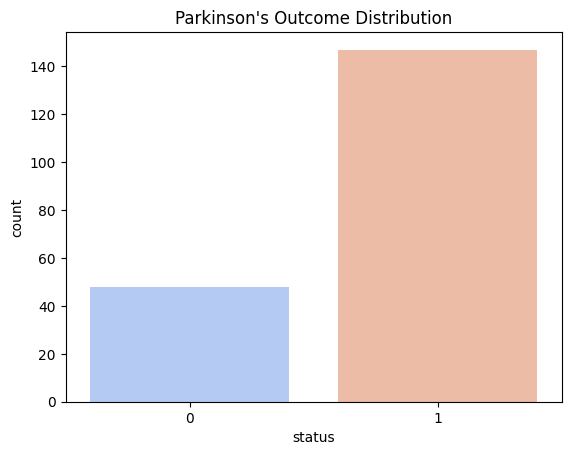

In [10]:
print(data.describe())

sns.countplot(x=data['status'], palette='coolwarm')
plt.title("Parkinson's Outcome Distribution")
plt.show()

In [13]:
X = data.drop(columns=["status", "name"])
y = data["status"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (156, 22)
Testing Data Shape: (39, 22)


In [15]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'n_estimators': [100, 200, 300] 
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print("XGBoost Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("XGBoost Testing  Accuracy:", accuracy_score(y_test, y_pred_test))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Training Accuracy: 1.0
XGBoost Testing  Accuracy: 0.9487179487179487
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



In [16]:
param_grid2 = {
    'max_depth': [3, 5, 7],  
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.3, 0.5], 
}

grid_search2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        n_estimators=200,
        subsample=0.6,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    param_grid=param_grid2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search2.fit(X_train, y_train)

print("Best Parameters after second tuning:", grid_search2.best_params_)

best_xgb2 = xgb.XGBClassifier(**grid_search2.best_params_, 
                              colsample_bytree=1.0, 
                              learning_rate=0.01, 
                              n_estimators=200, 
                              subsample=0.6, 
                              use_label_encoder=False, 
                              eval_metric="logloss")

best_xgb2.fit(X_train, y_train)

y_pred_train2 = best_xgb2.predict(X_train)
y_pred_test2 = best_xgb2.predict(X_test)

print("XGBoost Training Accuracy (After Second Tuning):", accuracy_score(y_train, y_pred_train2))
print("XGBoost Testing Accuracy (After Second Tuning):", accuracy_score(y_test, y_pred_test2))
print("XGBoost Classification Report (After Second Tuning):\n", classification_report(y_test, y_pred_test2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters after second tuning: {'gamma': 0, 'max_depth': 5, 'min_child_weight': 1}
XGBoost Training Accuracy (After Second Tuning): 0.9743589743589743
XGBoost Testing Accuracy (After Second Tuning): 0.9487179487179487
XGBoost Classification Report (After Second Tuning):
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



In [17]:
import pickle
import joblib
import xgboost as xgb

with open("xgboost_parkinsons_model.pkl", "wb") as file:
    pickle.dump(best_xgb2, file)

joblib.dump(best_xgb2, "xgboost_parkinsons_model.joblib")

print("✅ Model saved successfully!")

✅ Model saved successfully!


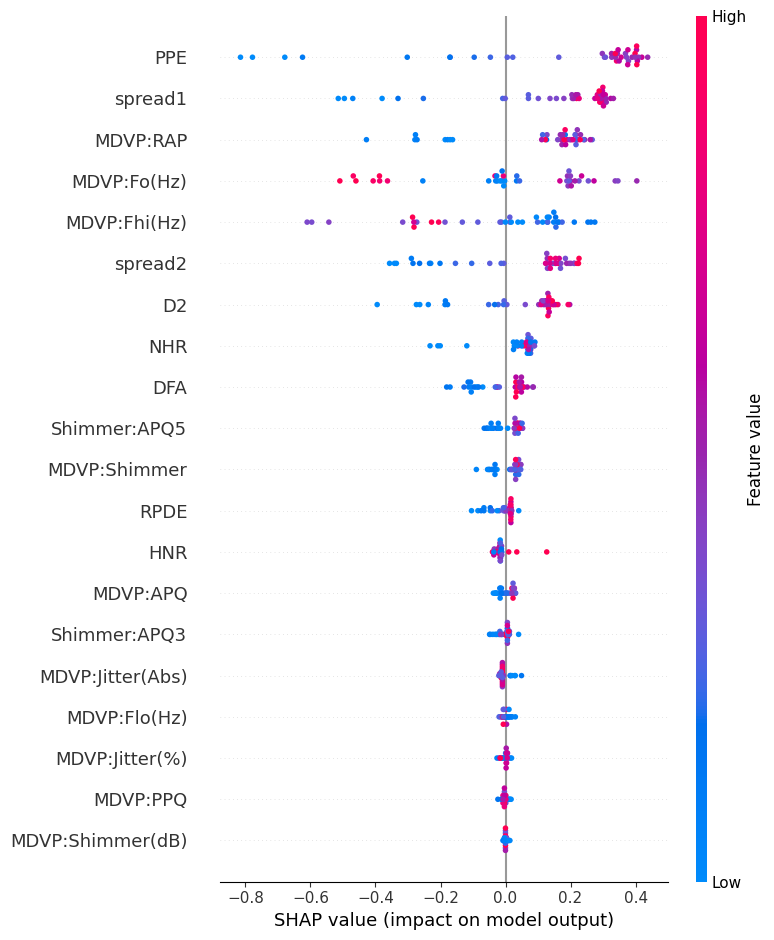

In [18]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(best_xgb2, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [19]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

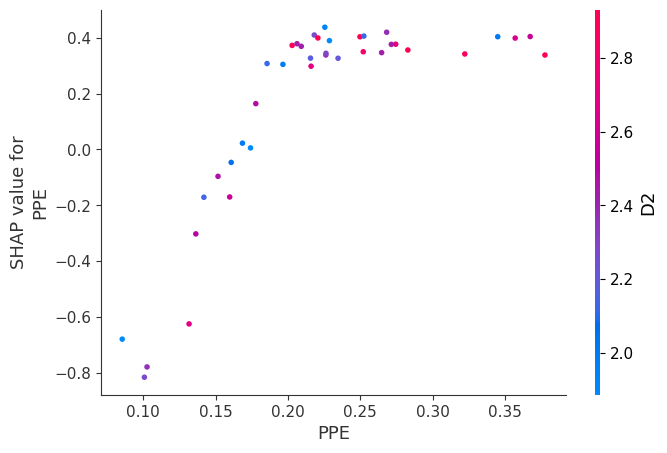

In [21]:
shap.dependence_plot("PPE", shap_values.values, X_test)